In [ ]:
import pandas as pd
import json

In [ ]:
file_path = r"/content/img_urls.csv"

In [ ]:
df = pd.read_csv(file_path, index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11720 entries, 0 to 11719
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 11720 non-null  object 
 1   attribution             11720 non-null  object 
 2   copyright_license       11720 non-null  object 
 3   age_approx              11337 non-null  float64
 4   anatom_site_general     9558 non-null   object 
 5   anatom_site_special     537 non-null    object 
 6   benign_malignant        9042 non-null   object 
 7   concomitant_biopsy      11720 non-null  bool   
 8   diagnosis               11720 non-null  object 
 9   diagnosis_1             11720 non-null  object 
 10  diagnosis_2             11720 non-null  object 
 11  diagnosis_3             11540 non-null  object 
 12  diagnosis_confirm_type  11720 non-null  object 
 13  image_type              11719 non-null  object 
 14  lesion_id               11720 non-null  obj

In [ ]:
df.head(2)

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,anatom_site_special,benign_malignant,concomitant_biopsy,diagnosis,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_type,lesion_id,melanocytic,sex,img_url
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,NaN,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,dermoscopic,IL_7252831,True,male,https://content.isic-archive.com/034c4ee0-5a13...
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,NaN,benign,False,nevus,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,dermoscopic,IL_6125741,True,male,https://content.isic-archive.com/5b7ab18c-0456...


In [ ]:
import matplotlib.pyplot as plt

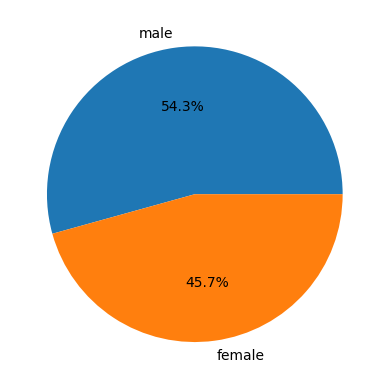

In [ ]:
data = df['sex'].value_counts()
plt.pie(data, labels=data.index, autopct="%1.1f%%");

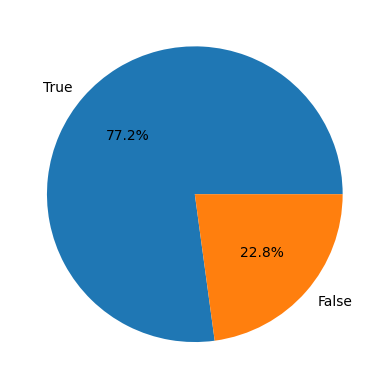

In [ ]:
data = df['melanocytic'].value_counts()
plt.pie(data, labels=data.index, autopct="%1.1f%%");

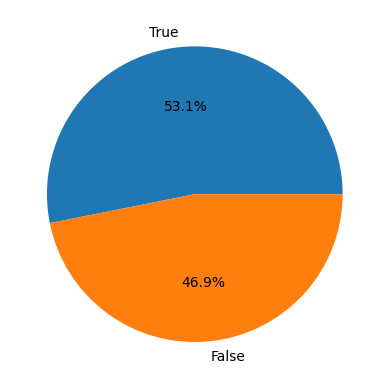

In [ ]:
data = df['concomitant_biopsy'].value_counts()
plt.pie(data, labels=data.index, autopct="%1.1f%%");

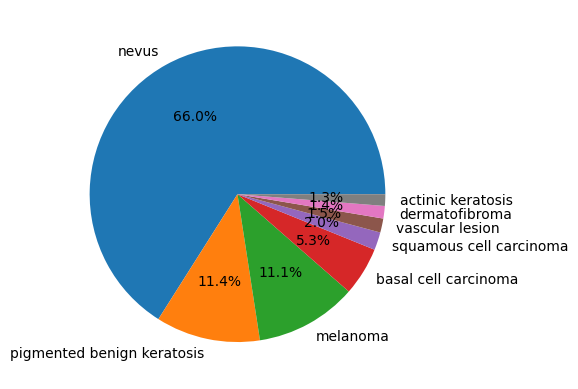

In [ ]:
data = df['diagnosis'].value_counts()
plt.pie(data, labels=data.index, autopct="%1.1f%%");

In [ ]:
!pip install timm
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from PIL import Image
import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from timm import create_model

In [ ]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.diagnosis_mapping = {label: idx for idx, label in enumerate(df['diagnosis'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_url = self.df.iloc[idx]['img_url']
        diagnosis = self.df.iloc[idx]['diagnosis']

        headers = {
            'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:134.0) Gecko/20100101 Firefox/134.0',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br, zstd',
            'Connection': 'keep-alive',
        }

        try:
            response = requests.get(img_url, headers=headers)
            image = Image.open(BytesIO(response.content)).convert('RGB')

            if self.transform:
                image = self.transform(image)
        except Exception as e:
            # Return a blank image if download fails
            # image = torch.zeros((3, 224, 224))
            print(f"error getting image for id: {idx}, error: {e}")

        label = self.diagnosis_mapping[diagnosis]
        return image, label

In [ ]:
class SkinDiseaseViT(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())
        return {'val_loss': loss, 'val_acc': acc}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

In [ ]:
class TrainingVisualizer:
    def __init__(self, model):
        self.model = model

    def plot_metrics(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.model.train_losses, label='Train Loss')
        plt.plot(self.model.val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.model.val_accs, label='Validation Accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
def prepare_data(df, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.RandomRotation(20),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

    train_dataset = SkinLesionDataset(train_df, transform=transform)
    val_dataset = SkinLesionDataset(val_df, transform=transform)
    print(len(train_dataset), len(val_dataset))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

    return train_loader, val_loader, len(train_dataset.diagnosis_mapping)

def train_model(df):
    train_loader, val_loader, num_classes = prepare_data(df)
    model = SkinDiseaseViT(num_classes=num_classes)

    trainer = pl.Trainer(
        max_epochs=20,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        # callbacks=[
        #     pl.callbacks.ModelCheckpoint(monitor='val_acc', mode='max'),
        #     pl.callbacks.EarlyStopping(monitor='val_acc', patience=3, mode='max')
        # ]
    )

    trainer.fit(model, train_loader, val_loader)

    visualizer = TrainingVisualizer(model)
    visualizer.plot_metrics()

    return model

9376 2344


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | VisionTransformer | 85.8 M | train
1 | criterion | CrossEntropyLoss  | 0      | train
--------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.219   Total estimated model params size (MB)
265       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


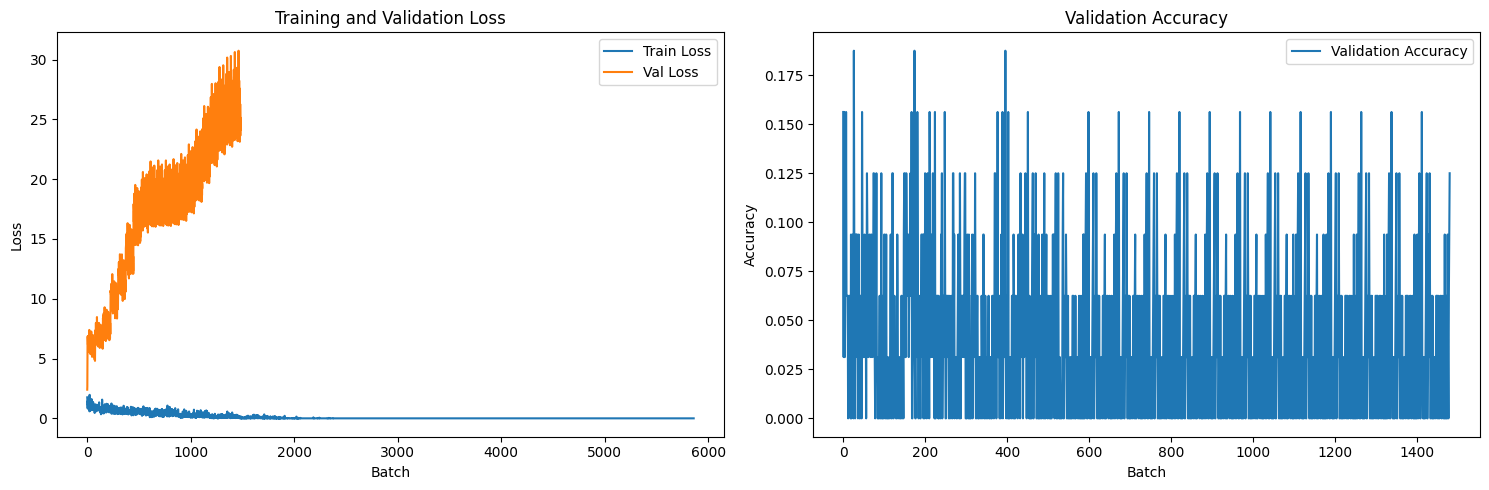

In [ ]:
model = train_model(df)

In [ ]:
torch.save(model.state_dict(), "vit_model_e20.pth")